### Importing required libraries

In [2]:
import pandas as pd
import numpy  as np
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
import spacy
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import tqdm
from pprint import pprint

### Reading the data from csv file

In [4]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv("scrappedtweets.csv")
# Print head
df.head()

,Datetime,Tweet Id,Text,Username
0,2023-04-13 02:56:08+00:00,1646346501101174786,"#Ukraine: In the video, a Ukrainian soldier wi...",WeaponsWarfare
1,2023-04-12 10:38:53+00:00,1646100569696632833,#Ukraine: A very rare video of a Ukrainian BSE...,WeaponsWarfare
2,2023-04-12 02:50:37+00:00,1645982725583585280,#Ukraine: Very rare video - American🇺🇲 BATT UM...,WeaponsWarfare
3,2023-04-07 18:01:33+00:00,1644400032362246145,"⚡️📢 Romanian media reports, that: ""Armenia ign...",ScourgeOfTengri
4,2023-04-07 07:36:00+00:00,1644242607021740032,The Ukrainian counter-offensive is likely to b...,ukraine_world


### Cleaning the data

In [6]:
# Remove the columns
df = df.drop(columns=['Datetime', 'Tweet Id', 'Username'], axis=1)

# Print out the first rows of tweets
df.head()

,Text
0,"#Ukraine: In the video, a Ukrainian soldier wi..."
1,#Ukraine: A very rare video of a Ukrainian BSE...
2,#Ukraine: Very rare video - American🇺🇲 BATT UM...
3,"⚡️📢 Romanian media reports, that: ""Armenia ign..."
4,The Ukrainian counter-offensive is likely to b...


In [9]:
# Remove punctuation
df['text_processed'] = df['Text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
df['text_processed'] = df['text_processed'].map(lambda x: x.lower())

In [10]:
df['text_processed'].head()

0    #ukraine: in the video a ukrainian soldier wit...
1    #ukraine: a very rare video of a ukrainian bse...
2    #ukraine: very rare video - american🇺🇲 batt um...
3    ⚡️📢 romanian media reports that: "armenia igno...
4    the ukrainian counter-offensive is likely to b...
Name: text_processed, dtype: object

### Word Tokenization

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [13]:
print(data_words[:1][0][:30])

['ukraine', 'in', 'the', 'video', 'ukrainian', 'soldier', 'with', 'box', 'with', 'finnish', 'frag', 'hand', 'grenades', 'and', 'right', 'next', 'to', 'the', 'box', 'large', 'number', 'of', 'jva', 'fuses', 'russia', 'russia', 'kyiv', 'finland', 'ukrainewar', 'ukraina']


### Topic Modelling : Bi-gram and Tri-gram

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

### Remove Stopwords, Make Bigrams and trigrams and Lemmatize

In [15]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bsaya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [18]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_model[bigram_model[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 10.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['video', 'frag', 'hand', 'grenade', 'right', 'next', 'box', 'large', 'number', 'fuse']


### Data transformation: Corpus and Dictionary
#### The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. 

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


### Base Model

In [24]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"say" + 0.010*"war" + 0.009*"zelenskyy" + 0.009*"start" + '
  '0.008*"country" + 0.008*"ukraine" + 0.008*"worldwar" + 0.007*"know" + '
  '0.007*"year" + 0.006*"tell"'),
 (1,
  '0.052*"russian" + 0.026*"ukrainian" + 0.015*"bakhmut" + 0.012*"video" + '
  '0.011*"destroy" + 0.011*"soldier" + 0.011*"say" + 0.010*"military" + '
  '0.009*"tco" + 0.009*"https"'),
 (2,
  '0.026*"russian" + 0.017*"today" + 0.016*"ukrainian" + 0.012*"map" + '
  '0.011*"invasion" + 0.011*"mine" + 0.010*"support" + 0.010*"day" + '
  '0.007*"tco" + 0.007*"border"'),
 (3,
  '0.027*"russian" + 0.012*"war" + 0.012*"tco" + 0.012*"attack" + '
  '0.009*"ukraine" + 0.009*"want" + 0.008*"language" + 0.008*"crime" + '
  '0.007*"https" + 0.007*"use"'),
 (4,
  '0.029*"war" + 0.022*"worldwar" + 0.021*"world" + 0.016*"situation" + '
  '0.016*"stop" + 0.015*"https" + 0.013*"intelligence_update" + '
  '0.013*"latest_defence" + 0.009*"end" + 0.009*"peace"'),
 (5,
  '0.025*"tco" + 0.017*"https" + 0.016*"ukrainian" + 0

### Model Perplexity and Coherence Score

In [26]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.27837877133374656


### Hyperparameter tuning

In [27]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [28]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./lda_tuning_results.csv', index=False)
    pbar.close()

 54%|█████████████████████████████████████████▏                                  | 293/540 [2:28:43<1:57:27, 28.53s/it]

KeyboardInterrupt: 

## Sentiment analysis using textblob

In [31]:
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud

In [37]:
def cleanTweets(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet) # Remove mentions
    tweet = re.sub(r'#', '', tweet)  # Remove hashtags
    tweet = re.sub(r'RT[\s]+', '', tweet)  # Remove retweets
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)  # Remove links
    
    return tweet

df["Text"] = df["Text"].apply(cleanTweets)

In [38]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

In [39]:
def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [40]:
df["Subjectivity"] = df["Text"].apply(getSubjectivity)
df["Polarity"] = df["Text"].apply(getPolarity)

df

,Text,text_processed,Subjectivity,Polarity
0,"Ukraine: In the video, a Ukrainian soldier wit...",#ukraine: in the video a ukrainian soldier wit...,0.321429,0.166667
1,Ukraine: A very rare video of a Ukrainian BSEM...,#ukraine: a very rare video of a ukrainian bse...,1.000000,0.390000
2,Ukraine: Very rare video - American🇺🇲 BATT UMG...,#ukraine: very rare video - american🇺🇲 batt um...,0.500000,0.195000
3,"⚡️📢 Romanian media reports, that: ""Armenia ign...","⚡️📢 romanian media reports that: ""armenia igno...",0.050000,-0.050000
4,The Ukrainian counter-offensive is likely to b...,the ukrainian counter-offensive is likely to b...,1.000000,0.000000
...,...,...,...,...
5248,"Today, my performance of this song was feature...",today my performance of this song was featured...,0.483333,0.466667
5249,The illegal and unprovoked invasion of Ukraine...,the illegal and unprovoked invasion of ukraine...,0.633333,0.166667
5250,Norway extends agreement on medical evacuation...,norway extends agreement on medical evacuation...,0.250000,0.000000
5251,Today we disbursed €1.5 billion of the Macro-F...,today we disbursed €15 billion of the macro-fi...,0.200000,-0.025000


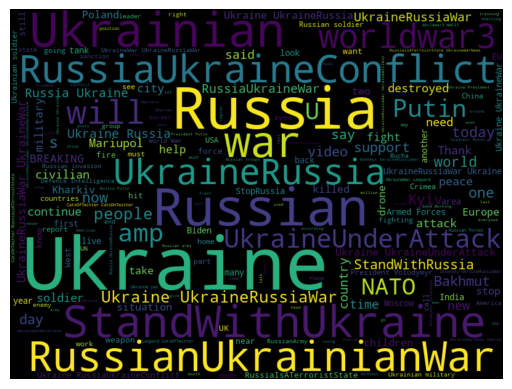

In [41]:
allWords = ' '.join( [twts for twts in df["Text"]] )
wordCloud = WordCloud(width=800, height=600, random_state=21, max_font_size=119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [42]:
# Save word cloud
wordCloud.to_file("word-cloud.png")

In [43]:
def getAnalysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"

In [44]:
# Applying getAnalysis function
df["Analysis"] = df["Polarity"].apply(getAnalysis)
df

,Text,text_processed,Subjectivity,Polarity,Analysis
0,"Ukraine: In the video, a Ukrainian soldier wit...",#ukraine: in the video a ukrainian soldier wit...,0.321429,0.166667,Positive
1,Ukraine: A very rare video of a Ukrainian BSEM...,#ukraine: a very rare video of a ukrainian bse...,1.000000,0.390000,Positive
2,Ukraine: Very rare video - American🇺🇲 BATT UMG...,#ukraine: very rare video - american🇺🇲 batt um...,0.500000,0.195000,Positive
3,"⚡️📢 Romanian media reports, that: ""Armenia ign...","⚡️📢 romanian media reports that: ""armenia igno...",0.050000,-0.050000,Negative
4,The Ukrainian counter-offensive is likely to b...,the ukrainian counter-offensive is likely to b...,1.000000,0.000000,Neutral
...,...,...,...,...,...
5248,"Today, my performance of this song was feature...",today my performance of this song was featured...,0.483333,0.466667,Positive
5249,The illegal and unprovoked invasion of Ukraine...,the illegal and unprovoked invasion of ukraine...,0.633333,0.166667,Positive
5250,Norway extends agreement on medical evacuation...,norway extends agreement on medical evacuation...,0.250000,0.000000,Neutral
5251,Today we disbursed €1.5 billion of the Macro-F...,today we disbursed €15 billion of the macro-fi...,0.200000,-0.025000,Negative


In [45]:
# Positive tweets
ptweets = df[df.Analysis == "Positive"]
ptweets = ptweets["Text"]
positive_percentage = round((ptweets.shape[0]/df.shape[0] * 100), 2)
print(f'Percentage of positive tweets: {positive_percentage}')

Percentage of positive tweets: 38.51


In [46]:
# Negative tweets
ntweets = df[df.Analysis == "Negative"]
ntweets = ntweets["Text"]
negetive_percentage = round((ntweets.shape[0]/df.shape[0] * 100), 2)
print(f'Percentage of negative tweets: {negetive_percentage}')

Percentage of negative tweets: 22.35


In [47]:
# Neutral tweets
neutweets = df[df.Analysis == "Neutral"]
neutweets = neutweets["Text"]
neutral_percentage = round((neutweets.shape[0]/df.shape[0] * 100), 2)
print(f'Percentage of neutral tweets: {neutral_percentage}')

Percentage of neutral tweets: 39.14


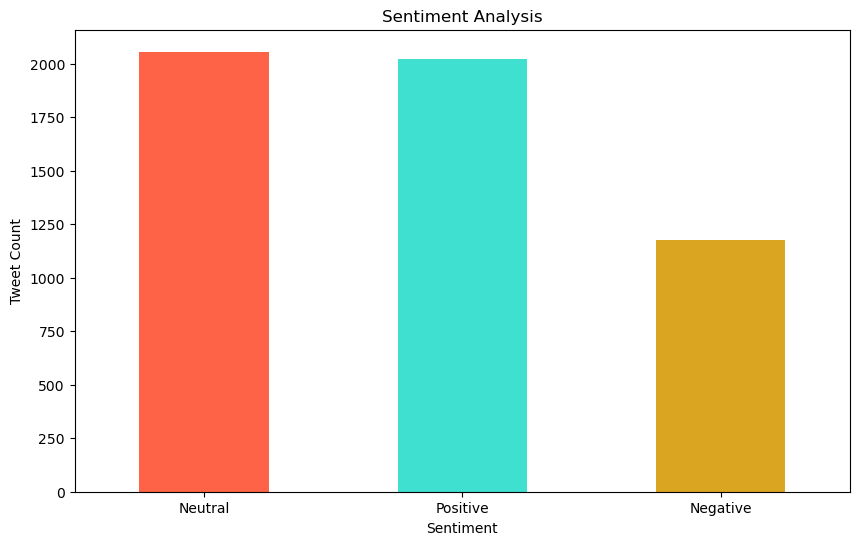

In [48]:
# Bar graph

plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
df["Analysis"].value_counts().plot(kind="bar", figsize = (10, 6), color=["tomato", "turquoise", "goldenrod"])
plt.xticks(rotation=0)
plt.show();

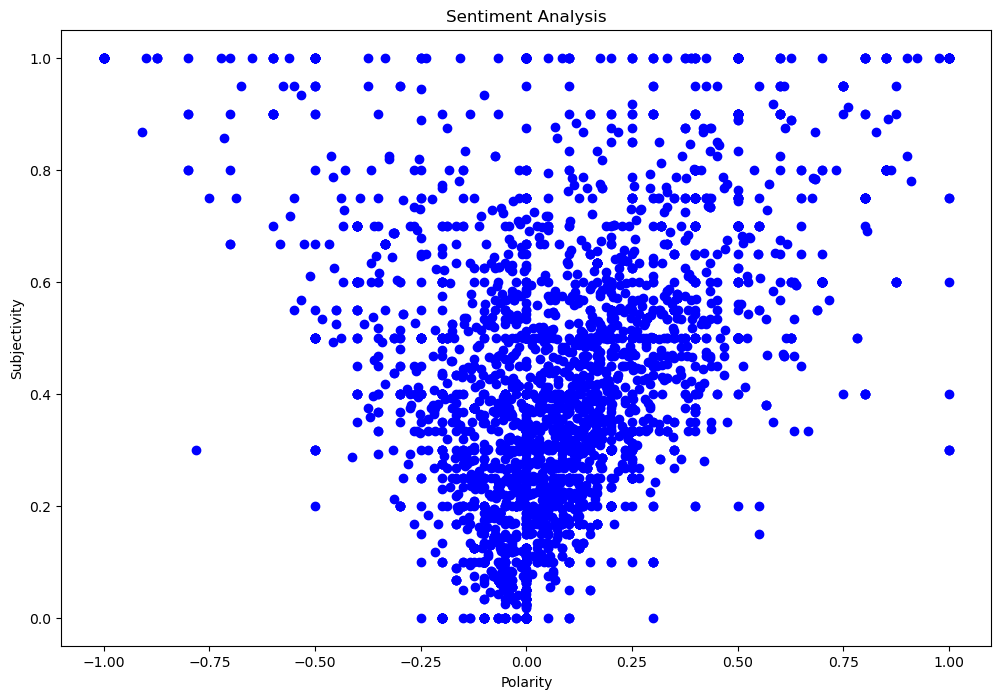

In [49]:
# Scatter plot
plt.figure(figsize=(12, 8))
for i in range(0, df.shape[0]):
    plt.scatter(df["Polarity"][i], df["Subjectivity"][i], color="Blue")
    
plt.title("Sentiment Analysis") 
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
plt.show();